## Hollowings
This notebook shows how a _hollowing_ (lavning) is computed. 

The goal is to be able to determine if a house is located in a hollwoing and thus 
has an increased risk of flooding if heavy rain occurs. 

We can achive this by using the _danish height model_ data set from [kortforsyningen](https://kortforsyningen.dk/indhold/webservice-liste-0). The data set is served in the [wms](https://en.wikipedia.org/wiki/Web_Map_Service) format. The data is returned as images where the pixal value for instance can indicate how big a hollowing is. 

We split the task into the following steps.
1. *Adress lookup:* We must be able to convert an adress of the form `Kjærmarken 103, 6771 gredstedbro` into a set of longtitude and latitude. 
2. *Image retrival:* Using the longtitude and latitude we retrive the relevant images and convert them to a useable format
3. *Compute the risk:* We use the image to compute the risk of flooding. 
4. *Construct final image:* To add transparency we combine the data images with a proper map and prepare an image that ilustrates the computation and can be shown to the end user. 


### Address lookup
We start by creating functions that can convert text adresses to coordinates, we use the [Dawa API](https://dawa.aws.dk/dok/api) to perform the lookups

In [1]:
import requests
import json
def addressToLatLong(address):
    response = requests.request(
        "GET", 
        "https://dawa.aws.dk/adgangsadresser", 
        params={"q": address,"struktur":"mini"}
    )
    data = json.loads(response.content)[0]
    return data['x'], data['y']

x, y = addressToLatLong("Kjærmarken 103, 6771 Gredstedbro")
assert x == 8.74228813
assert y == 55.40156089

#### Bouding box
To be able to retrive an image from a [WMS api](https://docs.geoserver.org/stable/en/user/services/wms/reference.html) with a langtitude and latitude pair we must compute a bounding box of the format `minx,miny,maxx,maxy`.

Dawa uses the [EPSG:4326](https://epsg.io/4326) projection which corrosponds to standard GPS coordinates. The WMS Api uses the [ESPG spatial refrence system](https://en.wikipedia.org/wiki/Spatial_reference_system), specifically the [EPSG:3857](https://epsg.io/3857) projection wich uses meters as units. 

We want to be able to specify a bounding box that has the latitude and longtidue as center of the box and then specify how many meters the box should extend in each direction. 

The steps of computing the bounding box is thus.
1. Convert from langtitude lotitude to EPSG:3857 projection. 
2. Create a box that has the specifyed with and height with the point in the center. 



In [2]:
from pyproj import Proj, transform
def convertEPSG(x, y):
    return transform(Proj(init='epsg:4326'), Proj(init='epsg:3857'), x, y)

x, y = addressToLatLong("Kjærmarken 103, 6771 Gredstedbro")
x, y = convertEPSG(x, y)
print(x,y)
assert x == 973187.0629996799
assert y == 7440194.196982217

973187.0629996799 7440194.196982217


In [3]:
def boundingBox(x, y, boxSize=200):
    minx = x - boxSize / 2
    miny = y - boxSize / 2
    maxx = x + boxSize / 2
    maxy = y + boxSize / 2
    return f'{minx},{miny},{maxx},{maxy}'

assert boundingBox(0,0, boxSize=2) == '-1.0,-1.0,1.0,1.0'

In [4]:
from PIL import Image
from io import BytesIO
import os
imageSize = 800

def getImg(x, y, feature, mode="L"):
    params = {
        "service": "WMS",
        "login": "rotendahl",
        "password": os.environ['KORTFORSYNINGEN_KEY'],
        "TRANSPARENT": "True",
        "VERSION": "1.1.1",
        "REQUEST": "GetMap",
        "FORMAT": "image/png",
        "SRS": "EPSG:3857",
        "BBOX": boundingBox(x,y),
        "WIDTH": str(imageSize),
        "HEIGHT": str(imageSize),
    }
    if feature == 'buildings':
        params["LAYERS"] = "BU.Building"
        params["servicename"] = "building_inspire"
  
    elif feature == 'hollowings':
        params["servicename"] = "dhm",
        params["LAYERS"] = "dhm_bluespot_ekstremregn"
        params["STYLES"] = "bluespot_ekstremregn_0_015"
        
    elif feature =='map':
        params["servicename"] = "orto_foraar",
        params["LAYERS"] = "orto_foraar"
        
    
    response = requests.request(
        "GET",
        "https://kortforsyningen.kms.dk/",
        params=params
    )
    img = Image.open(BytesIO(response.content))
    return img.convert(mode)

img = getImg(973187.0629996799,7440194.196982217, 'buildings')
assert img.size == (imageSize, imageSize)

In [6]:
# Combines the previous functions
def addressToImages(address):
    x,y = addressToLatLong(address)
    x,y = convertEPSG(x, y)
    return getImg(x, y, 'buildings'), getImg(x, y, 'hollowings'), getImg(x, y, 'map', mode="RGB"),
 
address = 'Dronning Dagmars vej 11, 6760 Ribe'     
buildImg, hollowImg, mapImg = addressToImages(address)

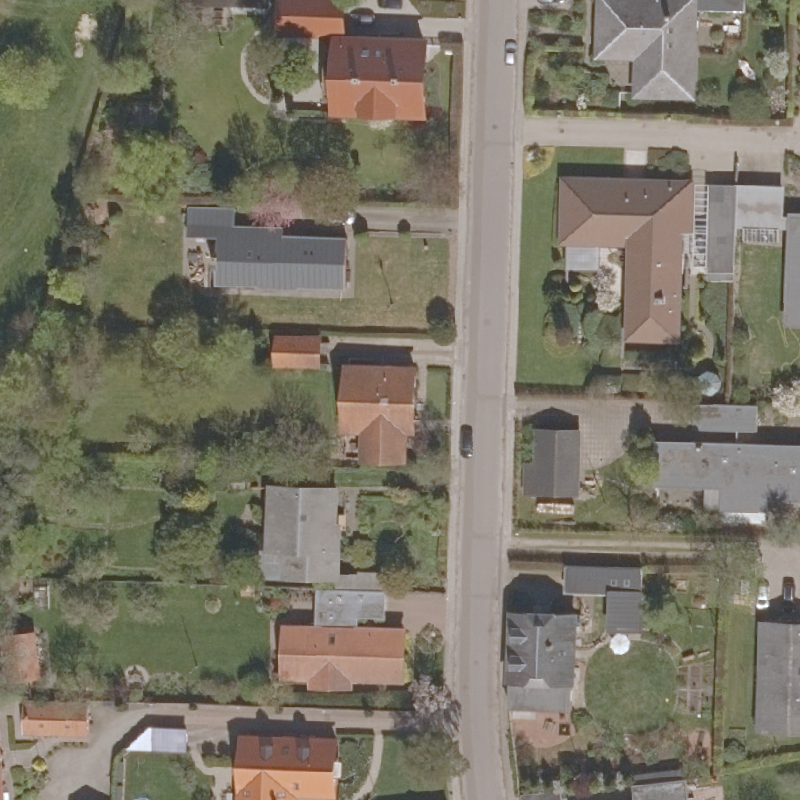

In [7]:
mapImg

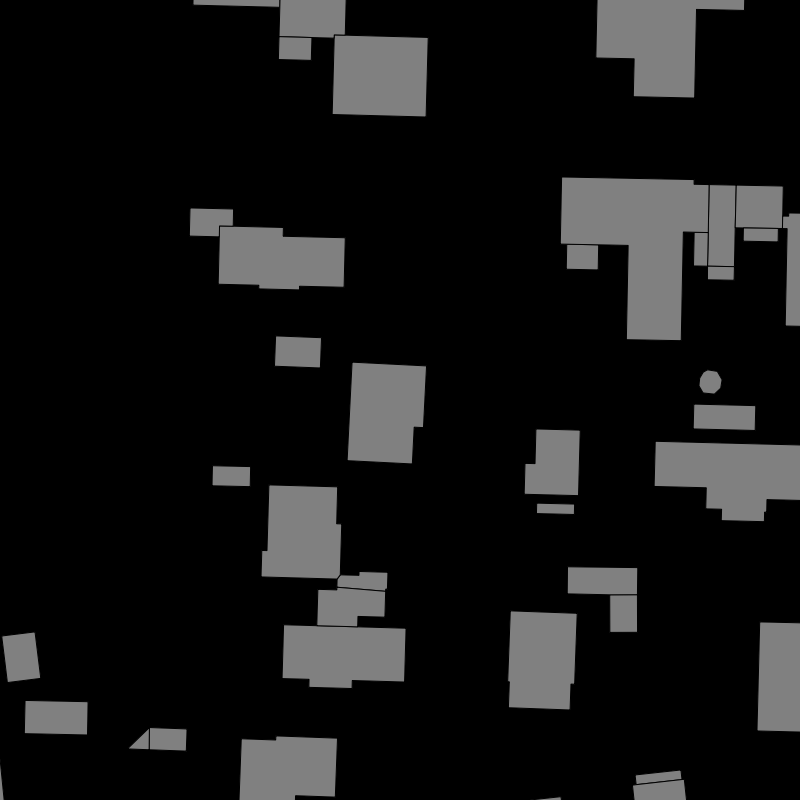

In [9]:
buildImg

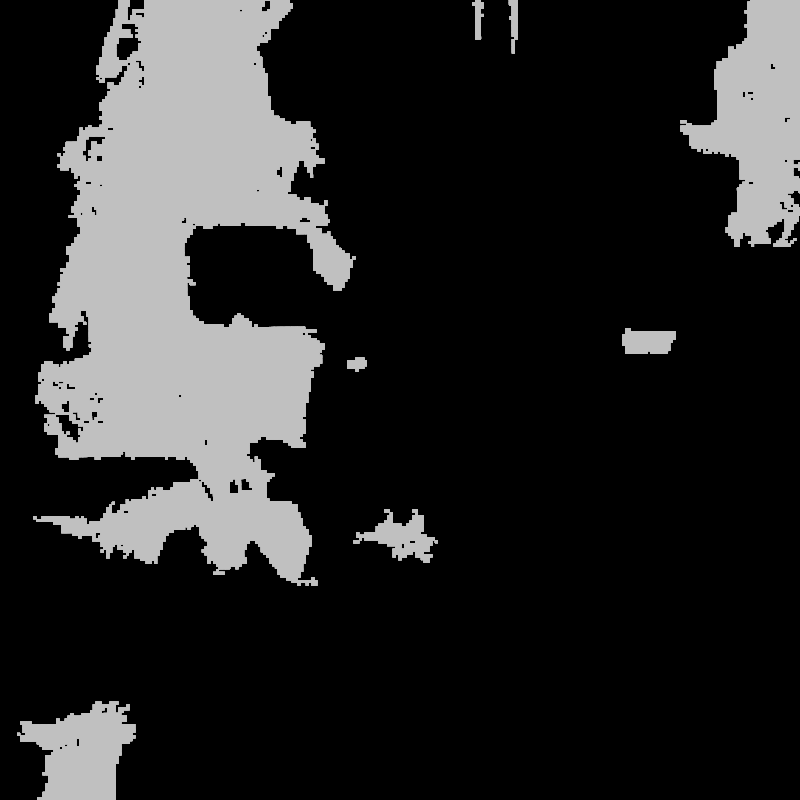

In [8]:
hollowImg

### Computing the values
As seen above we are now able to retrive bulding and hollowing data for an abitrary house. 

The next goal is to determine if there is a hollwoing in the specific bulding. The algorithm consists of the following steps. 
1. Isolate the main bulding on the property
2. Convert the building image to a binary image
3. Filter hollowings that are not touching a house
4. Count the number of pixels that is touching the house. 

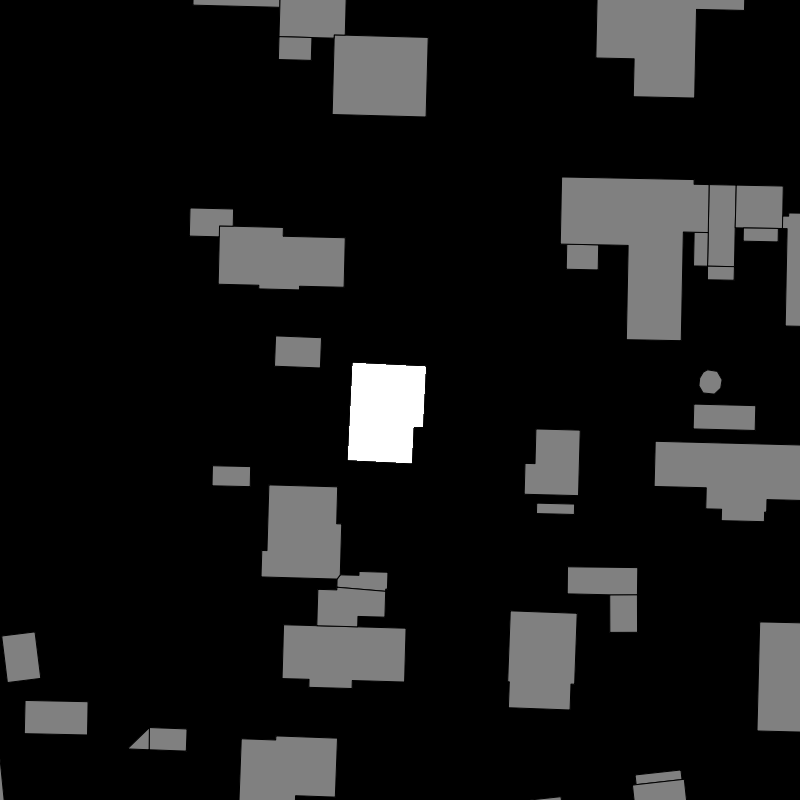

In [10]:
import numpy as np 
import pandas as pd
def checkNeighbours(arr, x, y, points):
        threshold = 80
        x_limit, y_limit = arr.shape
        neighbors = [[x + 1, y], [x - 1, y], [x, y - 1], [x, y + 1]]
        # filter neighbors that are out or range or not touching center
        neighbors = [
            (x, y)
            for x, y in neighbors
            if ((x >= 0 and y >= 0) and (x < x_limit and y < y_limit)) and 
            arr[x][y] > threshold and arr[x][y] < 255
        ]
        for (neighbor) in neighbors:
            points.add(neighbor)
            
def isolateBuilding(buildImg):
    arr = np.asarray(buildImg).copy()
    x, y = arr.shape 
    x, y = x // 2, y //2
    points = set([(x, y)])
    while(len(points) > 0):
        x, y = points.pop()
        arr[x][y] = 255
        checkNeighbours(arr, x, y, points)
    return Image.fromarray(arr)
    
            
isolateImg = isolateBuilding(buildImg)
isolateImg

#### Transforming the images
We are able to isolate the bulding and retrive hollwoings for the area. 
The next step is to use the isolated bulding as a filter on the hollwoing image and only show the hollowings that are touching the house. 

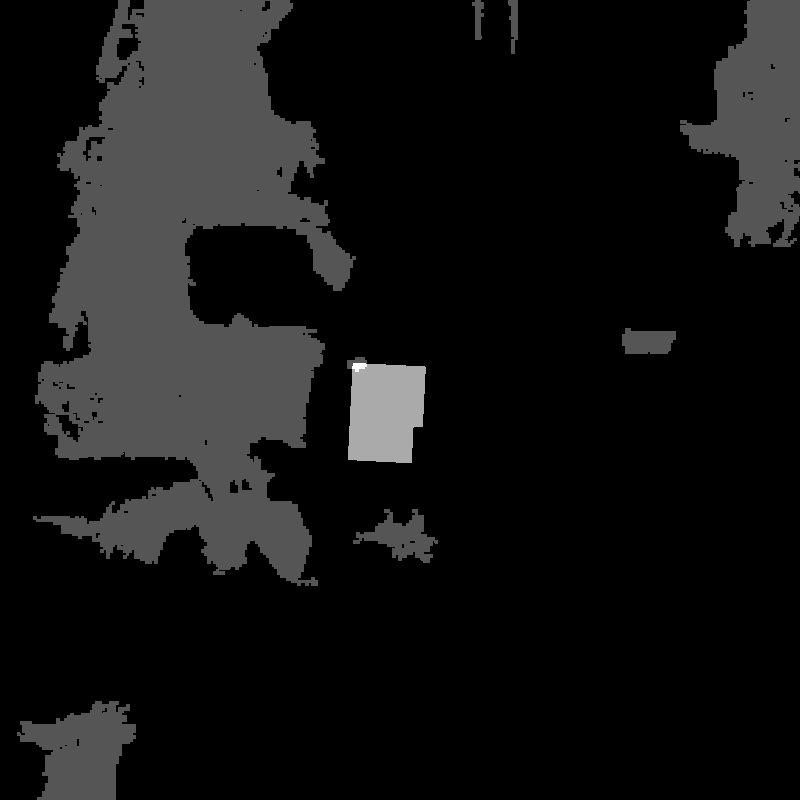

In [11]:
def imageToBlackWhite(img, thresshold=255):
    df = pd.DataFrame(np.asarray(img).copy())
    df[df < thresshold] = 0
    df[df > 0] = 255
    return Image.fromarray(df.values).convert('1')

def combineImages(img1, img2):
    img1 = pd.DataFrame(np.asarray(img1).copy()) * 85
    img2 = pd.DataFrame(np.asarray(img2).copy()) * 170
    combined = (img1 + img2).astype(float)
    return Image.fromarray(combined.values).convert('L')

combined = combineImages(
    imageToBlackWhite(hollowImg, thresshold=10),
    imageToBlackWhite(isolateImg)
)
combined

In [12]:
def numberPixelHollowings(hollowImg, isolateImg):
    combined = combineImages(
        imageToBlackWhite(hollowImg, thresshold=10),
        imageToBlackWhite(isolateImg)
    )
    return np.asarray(imageToBlackWhite(combined)).sum()

In [ ]:
numberPixelHollowings(hollowImg, isolateImg)

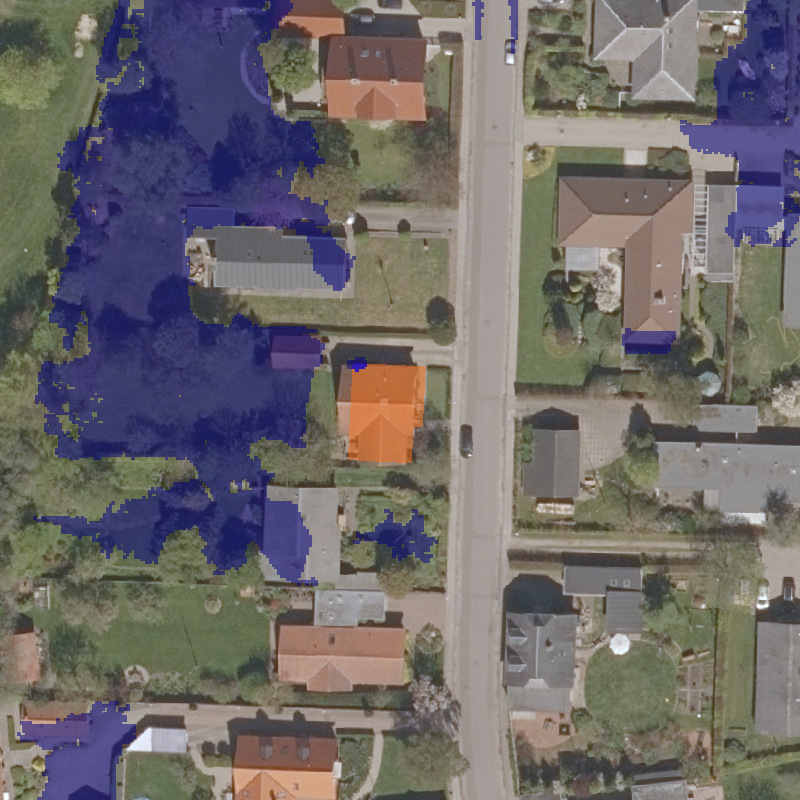

In [18]:
def replaceColor(img, original, new):
    img = np.array(img)
    img[(img == original).all(axis = -1)] = new
    img[(img != new).all(axis = -1)] = (255, 0, 0, 0)
    return Image.fromarray(img, mode='RGBA')

def prettyPng(mapI, isolateImg, hollowImg, combined):
    mapImg = mapI.copy()
    houseImg = replaceColor(
        imageToBlackWhite(isolateImg).convert('RGBA'),  
        (255, 255, 255, 255), 
        (247, 114, 30, 128)
    ) 
    mapImg.paste(houseImg, (0,0), houseImg)
    hollowImg = replaceColor(
        imageToBlackWhite(hollowImg, thresshold=10).convert('RGBA'), 
        (255, 255, 255, 255), 
        (1, 1, 128, 128), 
    )
    combined = replaceColor(
        imageToBlackWhite(combined).convert('RGBA'), 
        (255, 255, 255, 255), 
        (1, 1, 255, 128), 
    )
    mapImg.paste(hollowImg, (0,0), hollowImg)
    mapImg.paste(combined, (0,0), combined)
    return mapImg
prettyPng(mapImg, isolateImg, hollowImg, combined)

## Summary
We are now able to input an address and return the number of pixels of the house that touches a hollowing. We can also generate a picture that ilustrates the situation for the house

In [21]:
def checkHollowing(address):
    buildImg, hollowImg, mapImg = addressToImages(address)
    isolateImg = isolateBuilding(buildImg)
    combined = combineImages(
        imageToBlackWhite(hollowImg, thresshold=10),
        imageToBlackWhite(isolateImg)
    )
    numberPixels = numberPixelHollowings(hollowImg, isolateImg)
    img = prettyPng(mapImg, isolateImg, hollowImg, combined)
    return numberPixels, img

94


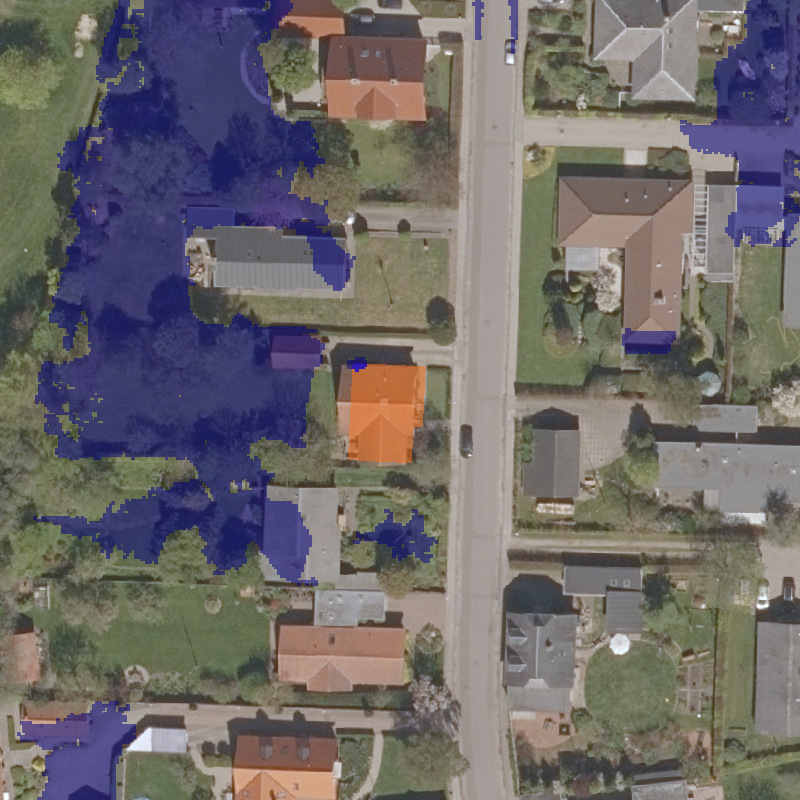

In [24]:
count, img = checkHollowing('Dronning Dagmars vej 11, 6760 Ribe')
print(count)
img